<a href="https://colab.research.google.com/github/Anubhav1107/First_One/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import torch.optim as optim
from torchvision import transforms, datasets,models
import requests



In [3]:
%matplotlib inline
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
from google.colab import files

In [68]:
name = files.upload()

Saving IMG20190118204036.jpg to IMG20190118204036.jpg


In [45]:
nam2 = files.upload()

Saving im.jpg to im.jpg


In [0]:

content = load_image('IMG20190118204036.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('im.jpg', shape=content.shape[-2:]).to(device)

In [0]:
#nd converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

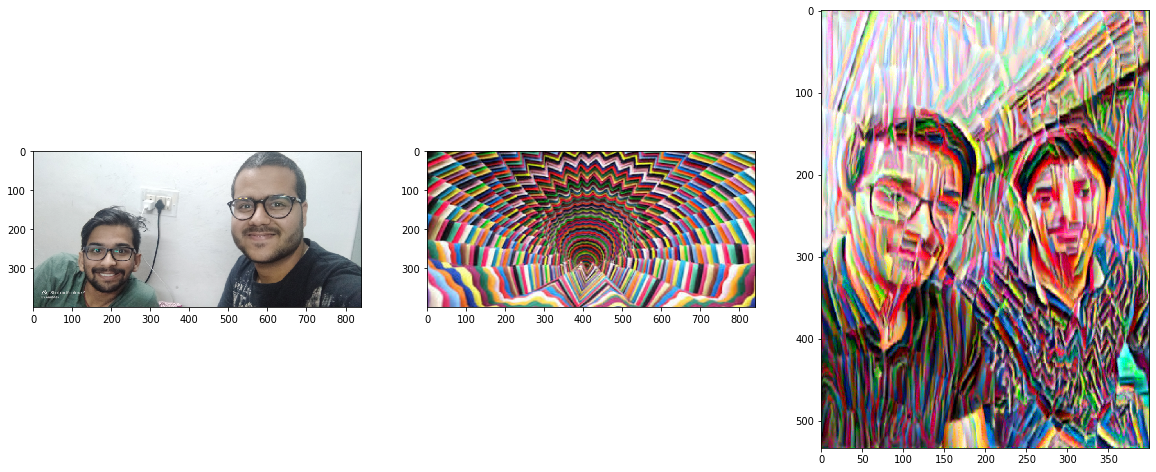

In [71]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))

In [72]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
#@title Below, complete the mapping of layer names to the names found in the paper for the content representation and the style representation

In [0]:
def get_features(image,model,layers=None):
  #Run a image forward through a model
  #and get the features for a set of layer

  if layers is None:
    layers = {'0':'conv1_1',
              '5':'conv2_1',
              '10':'conv3_1',
              '19':'conv4_1',
              '21':'conv4_2',#Content representation
              '28':'conv5_1'}

  features ={}
  x = image
  for name,layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [0]:
#We have to get the Gram matrix

def gram_matrix(tensor):
  #Get the batch_size,depth,height and width of a tensor
  _,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)

  #Calculate the gram matrix
  gram = torch.mm(tensor,tensor.t())

  return gram


In [0]:
#Putting it all together


#gettinfg feature
content_features  = get_features(content,vgg)
style_features = get_features(style,vgg)

#Calculate the gram matrices
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

#Creating the third image
target = content.clone().requires_grad_(True).to(device)



In [77]:
target

tensor([[[[ 1.6495,  1.6153,  1.6153,  ...,  1.7180,  1.7352,  1.7180],
          [ 1.6667,  1.6153,  1.5982,  ...,  1.7180,  1.7180,  1.7523],
          [ 1.6324,  1.6153,  1.5982,  ...,  1.7180,  1.7352,  1.7523],
          ...,
          [-1.0904, -1.0390, -0.9705,  ..., -1.3815, -1.4500, -1.3644],
          [-0.9192, -0.9534, -0.9363,  ..., -1.4329, -1.5014, -1.4329],
          [-0.9534, -0.9020, -0.9363,  ..., -1.3644, -1.3987, -1.4843]],

         [[ 1.9034,  1.8859,  1.9209,  ...,  1.9734,  2.0084,  1.9909],
          [ 1.9209,  1.9034,  1.9034,  ...,  1.9734,  1.9734,  2.0084],
          [ 1.9384,  1.9209,  1.9209,  ...,  1.9734,  1.9909,  2.0084],
          ...,
          [-0.4601, -0.4251, -0.3375,  ..., -1.1604, -1.1954, -1.0903],
          [-0.2850, -0.3550, -0.3025,  ..., -1.2129, -1.2479, -1.1604],
          [-0.3375, -0.3025, -0.3200,  ..., -1.1429, -1.1604, -1.2304]],

         [[ 2.1694,  2.1520,  2.1694,  ...,  2.2391,  2.2217,  2.2043],
          [ 2.1868,  2.1694,  

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 0.2,
                 'conv2_1': 0.2,
                 'conv3_1': 0.75,
                 'conv4_1': 0.75,
                 'conv5_1': 1.}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  9857598.0


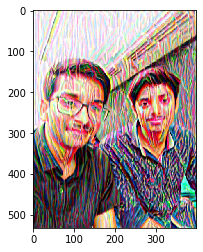

Total loss:  5493010.0


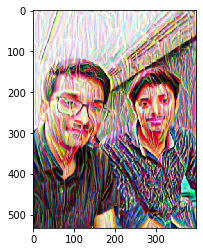

Total loss:  3865527.25


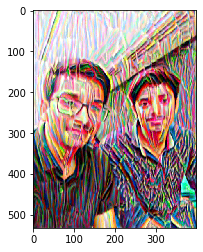

Total loss:  3041743.0


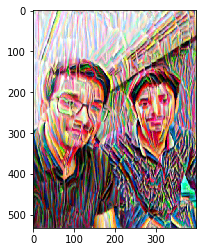

Total loss:  2543183.75


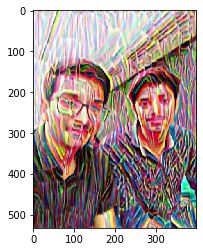

In [62]:
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

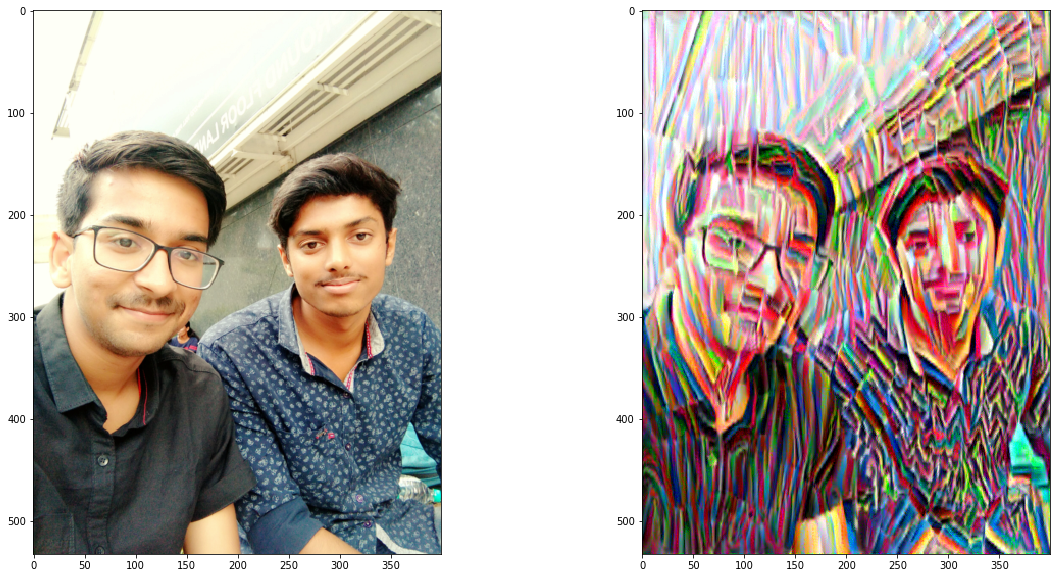

In [63]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

In [65]:
torch.save

<function torch.serialization.save>